### Universidad Panamericana
#### Ingeniería en Inteligencia de Datos y Ciberseguridad. Inteligencia Artificial
**Proyecto Final: Redes Neuronales Regresión**

Versión 5.
&nbsp;

Integrantes:
&nbsp;

&nbsp;&nbsp;&nbsp;Magos Fragoso Camila Joana &nbsp;&nbsp;0230821
&nbsp;

&nbsp;&nbsp;&nbsp;Voticky Osorio Fernando &nbsp;&nbsp;0222993
&nbsp;

Fecha de entrega: 23 mayo 2024

##Propósito
###Entender el comportamiento de empresas en la bolsa de valores cuyo precio esté mayormente ligado al tiempo y no a factores externos, para así poder realizar predicciones y hacer inversiones informadas sobre aquellas empresas.


##Instrucciones
###Instalar dependencias correspondientes: yfinance, numpy, sklearn, tensorflow, matplotlib y kerastuner.
###Teniéndolas instaladas, Se hacen los cambios correspondientes mencionados en el manual de usuario y se elige la opción de “Runtime run all”.


In [ ]:
!pip install -q -U keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.3 MB/s eta 0:00:00


#Dependencias

In [ ]:
# Librerías por usar
import yfinance as yf # Descarga datos financieros de Yahoo Finance.
import numpy as np # Soporte para cálculos con matrices y datos numéricos.
from sklearn.preprocessing import MinMaxScaler # Normaliza los datos a un rango específico (0-1).
from tensorflow.keras.models import Sequential # Crea modelos de redes neuronales secuenciales.
from tensorflow.keras.layers import Dense, LSTM, Dropout # Dense: capa totalmente conectada. LSTM: redes neuronales para series temporales. Dropout: regularización para prevenir el sobreajuste.
import tensorflow as tf # Biblioteca de aprendizaje automático y redes neuronales.
import matplotlib.pyplot as plt # Creación de gráficos y visualizaciones.
import matplotlib.dates as mdates # Manejo y formato de fechas en gráficos.
from kerastuner import HyperModel # Define modelos de Keras para la búsqueda de hiperparámetros.
from kerastuner.tuners import RandomSearch # Búsqueda aleatoria de la mejor combinación de hiperparámetros.


<ipython-input-8-8a38fbf23259>:10: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel # Define modelos de Keras para la búsqueda de hiperparámetros.


#Variables Globales

##Modelo Base

###Escalamiento de Datos

In [ ]:
empresa = 'BIMBOA.MX' #Empresa sobre la que se hace la predicción
stock_data_bimbo = yf.download(empresa, start='2000-01-01', end='2024-05-30') #Datos de los preciosde la bolsa en un periodo dado
valor_accion = stock_data_bimbo[['Close']].values.astype(float) #Columna con los precios de close

# Definimos escalador de información
scaler = MinMaxScaler()
scaled_close_data = scaler.fit_transform(valor_accion)

seq_length = 30  # Secuencias mensuales

# Divisiones para escalamiento
X = []
y = []
for i in range(len(scaled_close_data) - seq_length):
    X.append(scaled_close_data[i:i+seq_length])
    y.append(scaled_close_data[i+seq_length])  # Predicción

X, y = np.array(X), np.array(y)

# Partición 80-20 de los datos para entrenar y probar
split_ratio = 0.8
split_index = int(split_ratio * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Modelo LSTM por ser serie de tiempo
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')

# Entrenamiento
history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)

# Configurar el tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  # Número de combinaciones de hiperparámetros a probar
    executions_per_trial=3,  # Número de veces que se ejecutará cada combinación para reducir la variabilidad
    directory='my_dir',
    project_name='hyperparameter_tuning')


[*********************100%%**********************]  1 of 1 completed


Epoch 1/30
124/124 [==============================] - 3s 16ms/step - loss: 0.0012 - val_loss: 2.0149e-04
Epoch 2/30
124/124 [==============================] - 2s 14ms/step - loss: 4.3587e-05 - val_loss: 2.6423e-04
Epoch 3/30
124/124 [==============================] - 2s 20ms/step - loss: 4.3720e-05 - val_loss: 1.2568e-04
Epoch 4/30
124/124 [==============================] - 3s 26ms/step - loss: 4.1108e-05 - val_loss: 1.6861e-04
Epoch 5/30
124/124 [==============================] - 2s 14ms/step - loss: 4.0559e-05 - val_loss: 1.1885e-04
Epoch 6/30
124/124 [==============================] - 2s 15ms/step - loss: 4.2558e-05 - val_loss: 1.1817e-04
Epoch 7/30
124/124 [==============================] - 2s 14ms/step - loss: 3.8837e-05 - val_loss: 1.0824e-04
Epoch 8/30
124/124 [==============================] - 2s 14ms/step - loss: 4.5123e-05 - val_loss: 1.4514e-04
Epoch 9/30
124/124 [==============================] - 2s 16ms/step - loss: 4.2515e-05 - val_loss: 1.0754e-04
Epoch 10/30
124/124 [==

#Funciones Principales

In [ ]:
# Definir el modelo con hiperparámetros, nos ayuda a encontrar el mejor modelo para este problema usando el parámetro del tuneador
def build_model(hp): #Hiper parámetros
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                   activation=hp.Choice('activation', values=['relu', 'tanh']),
                   input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1))) #Regulariza el modelo para no overshootear ajustes
    model.add(Dense(1))

    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error')

    return model #Regresa el modelo para futura comparación

#Para esta red neuronal, no se utilizaron Funciones de Apoyo

#Análisis de los Datos

In [ ]:
valor_accion.max() #Maximo

98.97000122070312

In [ ]:
valor_accion.min() #Minimo

2.8375000953674316

In [ ]:
valor_accion.mean() #Promedio

29.8945048414255

In [ ]:
np.median(valor_accion) #Mediana

28.730000495910645

In [ ]:
np.std(valor_accion) #Desviación estándar

22.458214372609206

#Gráfico de los datos

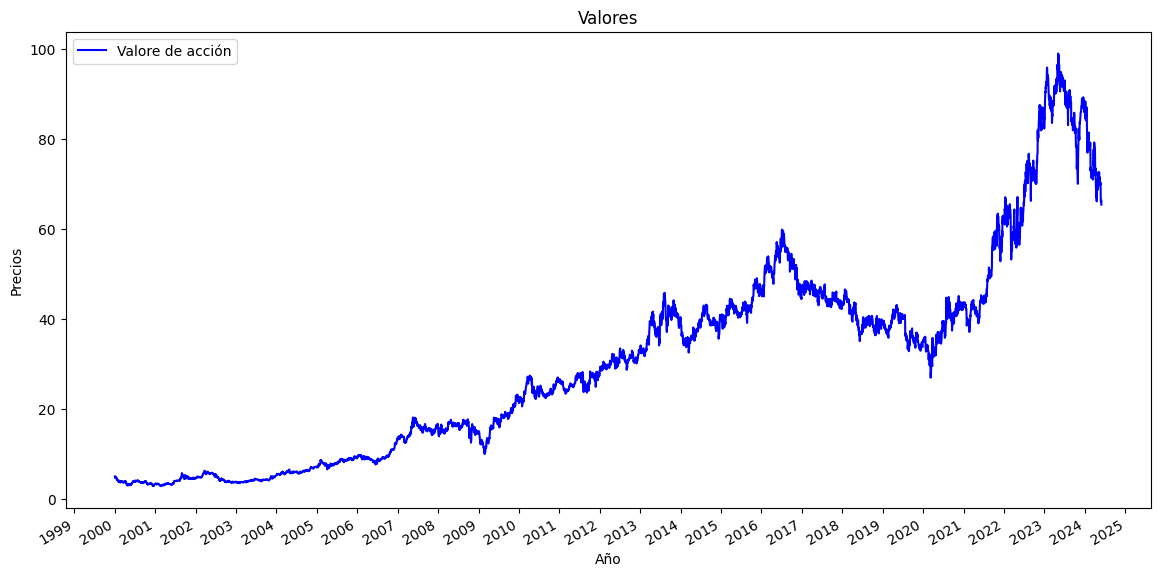

In [ ]:
valor_accion_grafica = stock_data_bimbo[['Close']] #Obtenemos precios y fechas

plt.figure(figsize=(14, 7))
plt.plot(stock_data_bimbo.index, valor_accion_grafica, label='Valore de acción', color='blue')

plt.xlabel('Año')
plt.ylabel('Precios')
plt.title('Valores')
plt.legend()

# Formateo para enseñar el año
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

plt.show()

#Evaluación del Modelo
###En este caso, se eligió usar el error cuadrático por la naturaleza de la regresión y porque se están tratando datos de una serie de tiempo.

In [ ]:
#Métrica de error cuadrático
mse = model.evaluate(X_test, y_test)
print(f'Error cuadrático {mse}')

39/39 [==============================] - 0s 9ms/step - loss: 3.0318e-04
Mean Squared Error (MSE) on test set: 0.00030318304197862744


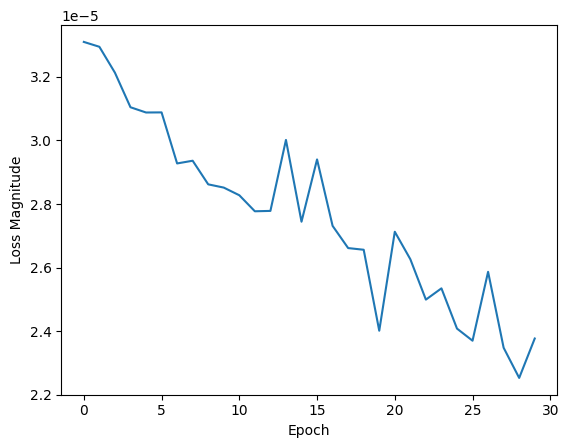

In [ ]:
#Gráfica de pérdida
plt.xlabel('Epoch')
plt.ylabel("Pérdida")
plt.plot(history.history['loss'])

##Predicción de los siguientes 10 días

In [ ]:
# Segmento para predicción
last_sequence = scaled_close_data[-seq_length:].reshape((1, seq_length, 1))

# Días a predecir
num_days = 10

# Predicción
predicted_prices = []
for _ in range(num_days):
    predicted_value = model.predict(last_sequence)[0, 0]  # Obtenemos valor
    predicted_prices.append(predicted_value)  # Guardamos valor
    # Actualizamos last_sequence
    last_sequence = np.concatenate((last_sequence[:, 1:, :], np.array(predicted_value).reshape(1, 1, 1)), axis=1)

# Deshacer la transformación
predicted_stock_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

print("Predicted Stock Prices for the Next", num_days, "Days:")
print(predicted_stock_prices)


1/1 [==============================] - 0s 23ms/step
Predicted Stock Prices for the Next 10 Days:
[[65.04232 ]
 [64.54294 ]
 [64.06176 ]
 [63.599854]
 [63.15676 ]
 [62.73317 ]
 [62.32768 ]
 [61.938553]
 [61.562874]
 [61.20027 ]]


#Comparación Datos vs Modelo

39/39 [==============================] - 1s 13ms/step


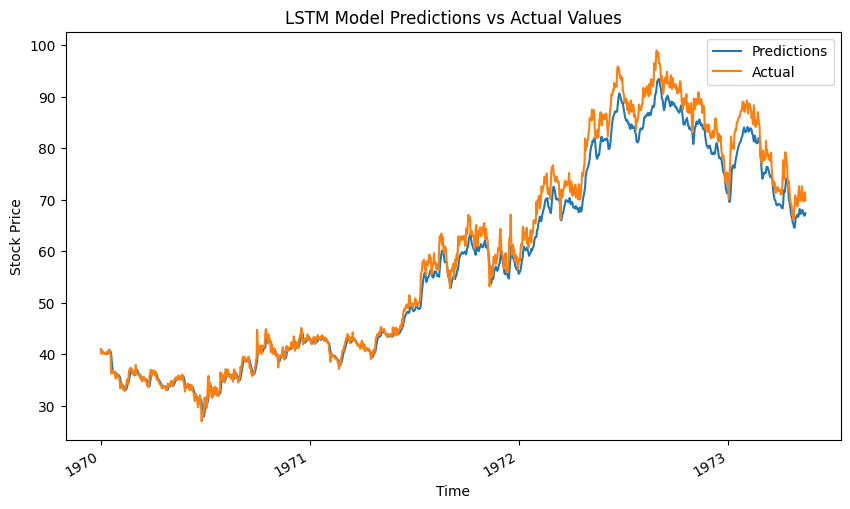

In [ ]:
#Generamos predicciones sobre las fechas de prueba para comparación
predictions = model.predict(X_test)

# De-escalamos los valores
predictions_inv = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test)

# Gráfico de comparación
plt.figure(figsize=(10, 6))
plt.plot(predictions_inv, label='Prediccidn')
plt.plot(y_test_inv, label='Valor')
plt.xlabel('Año')
plt.ylabel('Valor Acción')
plt.legend()

# Eje x
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()  # Rotate and align the tick labels
plt.title('Predicción vs Hecho')
plt.show()

#Búsqueda por el mejor modelo

##Hiper-parámetros

In [ ]:
# Ejecutar la búsqueda de hiperparámetros
tuner.search(X_train, y_train,
             epochs=30,
             batch_size=32,
             validation_split=0.2,
             verbose=1)

# Obtener los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Construir el modelo con los mejores hiperparámetros
model_v = tuner.hypermodel.build(best_hps)

Trial 5 Complete [00h 30m 19s]
val_loss: 5.9796344430651516e-05

Best val_loss So Far: 5.9796344430651516e-05
Total elapsed time: 02h 46m 51s
Epoch 1/30
124/124 [==============================] - 4s 25ms/step - loss: 3.3103e-05 - val_loss: 8.6149e-05
Epoch 2/30
124/124 [==============================] - 3s 25ms/step - loss: 3.2950e-05 - val_loss: 8.3895e-05
Epoch 3/30
124/124 [==============================] - 3s 25ms/step - loss: 3.2134e-05 - val_loss: 1.3427e-04
Epoch 4/30
124/124 [==============================] - 3s 25ms/step - loss: 3.1046e-05 - val_loss: 9.9625e-05
Epoch 5/30
124/124 [==============================] - 3s 25ms/step - loss: 3.0881e-05 - val_loss: 9.2038e-05
Epoch 6/30
124/124 [==============================] - 3s 24ms/step - loss: 3.0884e-05 - val_loss: 1.1607e-04
Epoch 7/30
124/124 [==============================] - 3s 23ms/step - loss: 2.9276e-05 - val_loss: 1.1764e-04
Epoch 8/30
124/124 [==============================] - 3s 24ms/step - loss: 2.9362e-05 - val_los

##Entrenamiento del nuevo modelo

In [ ]:
# Entrenar el modelo final
history_v = model_v.fit(X_train, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/30
124/124 [==============================] - 19s 110ms/step - loss: 6.3595e-04 - val_loss: 1.8375e-04
Epoch 2/30
124/124 [==============================] - 12s 97ms/step - loss: 1.8022e-04 - val_loss: 0.0018
Epoch 3/30
124/124 [==============================] - 20s 164ms/step - loss: 2.0792e-04 - val_loss: 7.1981e-04
Epoch 4/30
124/124 [==============================] - 15s 122ms/step - loss: 1.8766e-04 - val_loss: 3.4093e-04
Epoch 5/30
124/124 [==============================] - 15s 118ms/step - loss: 1.3971e-04 - val_loss: 1.2966e-04
Epoch 6/30
124/124 [==============================] - 11s 89ms/step - loss: 1.1693e-04 - val_loss: 9.6137e-05
Epoch 7/30
124/124 [==============================] - 12s 93ms/step - loss: 1.2459e-04 - val_loss: 1.6622e-04
Epoch 8/30
124/124 [==============================] - 11s 91ms/step - loss: 1.1730e-04 - val_loss: 9.6924e-05
Epoch 9/30
124/124 [==============================] - 11s 92ms/step - loss: 1.2814e-04 - val_loss: 1.6159e-04
Epoch 10/3

##Evaluación del nuevo modelo

In [ ]:
#Métrica de error cuadrático
mse_v = model_v.evaluate(X_test, y_test)*transformador
print(f'Error cuadrático {mse_v}')

39/39 [==============================] - 1s 32ms/step - loss: 0.0031
Error cuadrático 3.098817076534033e-06


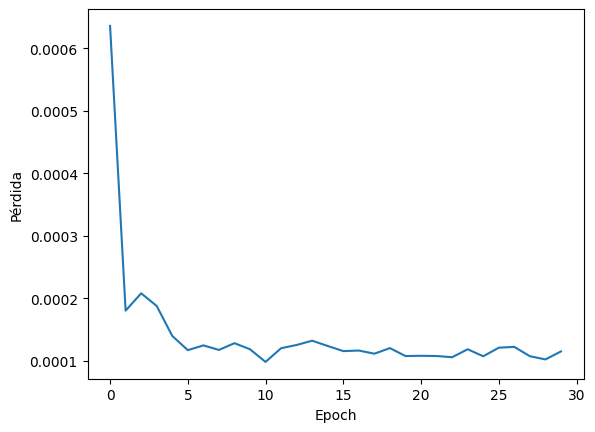

In [ ]:
#Gráfica de pérdida
plt.xlabel('Epoch')
plt.ylabel("Pérdida")
plt.plot(history_v.history['loss'])

##Testeo del mejor modelo

39/39 [==============================] - 2s 31ms/step


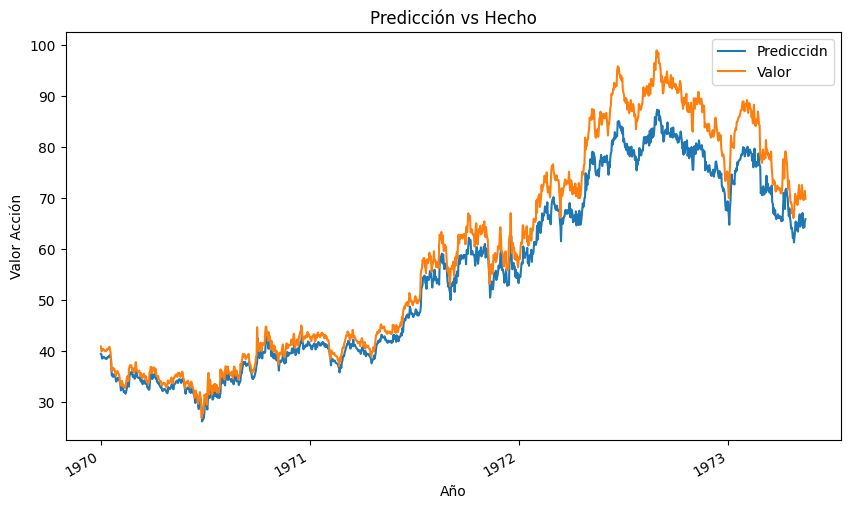

In [ ]:
#Generamos predicciones sobre las fechas de prueba para comparación
predictions = model_v.predict(X_test)

# De-escalamos los valores
predictions_inv = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test)

# Gráfico de comparación
plt.figure(figsize=(10, 6))
plt.plot(predictions_inv, label='Prediccidn')
plt.plot(y_test_inv, label='Valor')
plt.xlabel('Año')
plt.ylabel('Valor Acción')
plt.legend()

# Eje x
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()  # Rotate and align the tick labels
plt.title('Predicción vs Hecho')
plt.show()

In [ ]:
model_v.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 160)               103680    
                                                                 
 dropout_1 (Dropout)         (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 161       
                                                                 
Total params: 103841 (405.63 KB)
Trainable params: 103841 (405.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
